In [ ]:
from imutils import face_utils, rotate
import dlib
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.decomposition import PCA
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/mixed_data_v3.zip')
!unzip -q "/content/gdrive/MyDrive/mixed_data_v3.zip"

In [ ]:
p = "/content/gdrive/MyDrive/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [ ]:
def process_images(folder_path: str):
    """
    Process images from the given folder path and return a list of processed images.
    :param folder_path: folder path
    :return: list of processed images
    """
    # get all the images from the folder
    images = [cv2.imread(folder_path + '/' + image)
              for image in os.listdir(folder_path)]
    #images = [cv2.resize(image, (250,250)) for image in images]
    # convert the images to RGB
    #images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
    return images

def get_faces_landmarks(images):
  image_landmarks = []
  train_images = []

  for i,image in enumerate(images):
    # Get faces into webcam's image
    rects = detector(image, 0)

    #get face
    (x, y, w, h) = face_utils.rect_to_bb(rects[0])
    image = image[y:y+h, x:x+w]
    image = cv2.resize(image, (256, 256))
    rec = dlib.rectangle(left=0, top=0, right=256, bottom=256)

    #find the landmark.
    shape = predictor(image, rec)

    shape = face_utils.shape_to_np(shape)
    image_landmarks.append(shape)
    train_images.append(image)
  return train_images, image_landmarks


def get_features(train_landmarks):
  feature_vectors = []

  for landmarks in train_landmarks:
    nose_angle = math.atan((landmarks[27][1]-landmarks[30][1])
                          / (landmarks[27][0]-landmarks[30][0] + 10**-7))
    X_cog = np.mean(landmarks[:,0])
    Y_cog = np.mean(landmarks[:,1])
    X_relative = [i-X_cog for i in landmarks[:,0]]
    Y_relative = [i-Y_cog for i in landmarks[:,1]]
    EUC = [np.sqrt(np.square(i-X_cog) + np.square(j-Y_cog)) for (i,j) in landmarks]
    theta =  [math.atan((j - Y_cog) / (i - X_cog + 10**-7)) - nose_angle for (i,j) in landmarks]
    v = X_relative + Y_relative + EUC + theta
    feature_vectors.append(v)
  return feature_vectors

In [ ]:
x_angry = process_images('./mixed_data_v3/angry')
y_angry = [0]*len(x_angry)
x_disgust = process_images('./mixed_data_v3/disgust')
y_disgust = [1]*len(x_disgust)
x_fear = process_images('./mixed_data_v3/fear')
y_fear = [2]*len(x_fear)
x_happy = process_images('./mixed_data_v3/happy')
y_happy = [3]*len(x_happy)
x_neutral = process_images('./mixed_data_v3/neutral')
y_neutral = [4]*len(x_neutral)
x_sad = process_images('./mixed_data_v3/sad')
y_sad = [5]*len(x_sad)
x_surprise = process_images('./mixed_data_v3/surprise')
y_surprise = [6]*len(x_surprise)
data_x = x_angry + x_disgust + x_fear + x_happy + x_neutral + x_sad + x_surprise
data_y = y_angry + y_disgust + y_fear + y_happy + y_neutral + y_sad + y_surprise
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
faces_train, train_landmarks = get_faces_landmarks(X_train)
faces_test, test_landmarks = get_faces_landmarks(X_test)

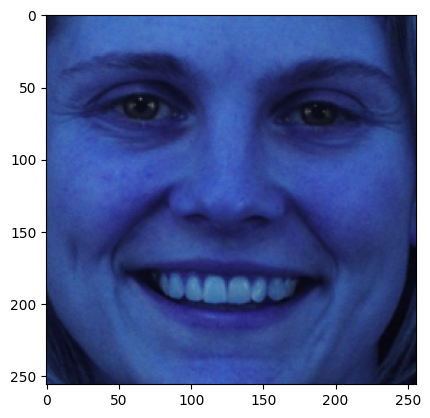

In [ ]:
plt.imshow(faces_train[6])

In [ ]:
true_landmarks = train_landmarks + test_landmarks
l = np.mean(true_landmarks, axis=0).astype(int)

In [ ]:
def extract_images_sift(images, images_landmarks, patch_size):
  sift = cv2.SIFT_create()
  images_sift_descriptors = []
  for image, image_landmarks in tqdm(zip(images, images_landmarks), total=len(images)):
    image_descriptors = []
    for landmarks_xy in image_landmarks:
        x,y = landmarks_xy[0], landmarks_xy[1]
        sift_points = []
        cv_landmark = cv2.KeyPoint(float(x), float(y), patch_size)

        sift_points += [cv_landmark, cv_landmark]
        _, descriptors = sift.compute(image, sift_points)
        image_descriptors.append(descriptors)
    images_sift_descriptors.append(image_descriptors)
  images_sift_descriptors = np.asarray(images_sift_descriptors)
  return images_sift_descriptors

In [ ]:
def fit(images, true_landmarks):
  images_current_landmarks = np.asarray([np.mean(true_landmarks, axis=0).astype(int) for _ in range(len(true_landmarks))])
  patch_size = 16
  regressors = []
  pcas = []
  for regressor_id in range(9):
    print("finding the sift descriptors")
    print('patch size = ', patch_size)
    images_sift_descriptors = extract_images_sift(images, images_current_landmarks, patch_size)
    #patch_size -= 4
    if regressor_id == 2:
      patch_size = 8
    if regressor_id == 5:
      patch_size = 4
    num_images, num_landmarks, num_landmark_coordinates, descriptor_size = images_sift_descriptors.shape
    descriptors = images_sift_descriptors.reshape(num_images,num_landmarks*num_landmark_coordinates*descriptor_size)
    print("getting PCA")
    pca = PCA(n_components=0.97)
    pca.fit(descriptors)
    pcas.append(pca)
    descriptors = pca.transform(descriptors)
    print("PCA is applied on the SIFT descriptors!")
    images_landmarks_diff = true_landmarks - images_current_landmarks
    images_landmarks_diff = images_landmarks_diff.reshape(num_images,num_landmarks*num_landmark_coordinates)
    #print(images_delta_landmarks)
    print(f"Training regressor num ",regressor_id)
    lr = LinearRegression()
    lr.fit(descriptors, images_landmarks_diff)
    regressors.append(lr)
    # predicting the diffrence between true and predicted landmarks
    predicted_landmarks_diff = lr.predict(descriptors)
    predicted_landmarks_diff = predicted_landmarks_diff.reshape(num_images,num_landmarks,num_landmark_coordinates)
    images_current_landmarks = images_current_landmarks + predicted_landmarks_diff.astype(int)
    print('acc= ', np.mean(np.sqrt(np.square(images_current_landmarks - true_landmarks))))
  return images_current_landmarks, regressors, pcas

In [ ]:
new_landmarks, regressors, pcas = fit(faces_train, train_landmarks)

finding the sift descriptors
patch size =  16


100%|██████████| 961/961 [03:59<00:00,  4.02it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  0
acc=  1.1654450021423761
finding the sift descriptors
patch size =  16


100%|██████████| 961/961 [05:14<00:00,  3.05it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  1
acc=  0.7953801187488523
finding the sift descriptors
patch size =  16


100%|██████████| 961/961 [04:13<00:00,  3.80it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  2
acc=  0.7822504131725531
finding the sift descriptors
patch size =  8


100%|██████████| 961/961 [03:08<00:00,  5.10it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  3
acc=  0.5924282303972578
finding the sift descriptors
patch size =  8


100%|██████████| 961/961 [03:06<00:00,  5.15it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  4
acc=  0.5767965354716288
finding the sift descriptors
patch size =  8


100%|██████████| 961/961 [03:06<00:00,  5.16it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  5
acc=  0.5732769174267002
finding the sift descriptors
patch size =  4


100%|██████████| 961/961 [03:01<00:00,  5.29it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  6
acc=  0.4648038195507131
finding the sift descriptors
patch size =  4


100%|██████████| 961/961 [03:00<00:00,  5.33it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  7
acc=  0.44725928873110116
finding the sift descriptors
patch size =  4


100%|██████████| 961/961 [02:59<00:00,  5.36it/s]


getting PCA
PCA is applied on the SIFT descriptors!
Training regressor num  8
acc=  0.441658505233519


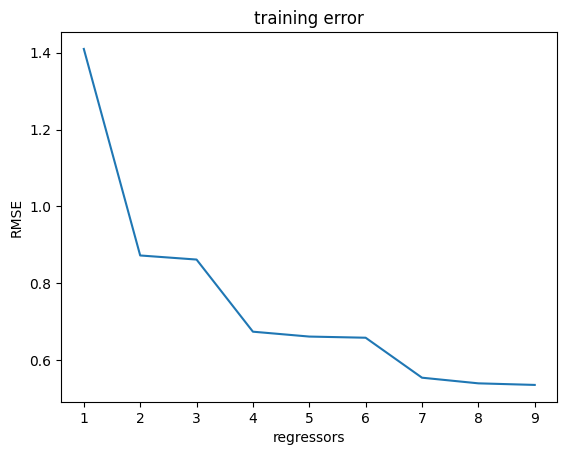

In [ ]:
training_acc = [1.4094, 0.8727, 0.86208, 0.67466, 0.66197, 0.65896, 0.5551, 0.540428, 0.536326]
plt.plot([1,2,3,4,5,6,7,8,9], training_acc)
plt.xlabel('regressors')
plt.ylabel('RMSE')
plt.title('training error')
plt.show()

In [ ]:
with open("sdm_pcas_models.pckl", "wb") as f:
    for model in pcas:
         pickle.dump(model, f)

In [ ]:
regressors = []
pcas = []
with open("/content/gdrive/MyDrive/sdm_regressors_models.pckl", "rb") as f:
    while True:
        try:
            regressors.append(pickle.load(f))
        except EOFError:
            break
with open("/content/gdrive/MyDrive/sdm_pcas_models.pckl", "rb") as f:
    while True:
        try:
            pcas.append(pickle.load(f))
        except EOFError:
            break

In [ ]:
exact_landmarks = np.array(train_landmarks)
print(np.mean(np.sqrt(np.square(new_landmarks - exact_landmarks))))

0.441658505233519


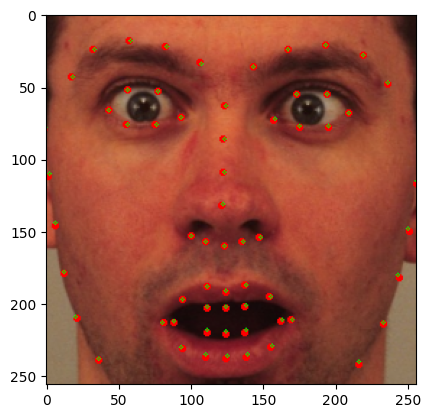

In [ ]:
ft = faces_train.copy()
lt = exact_landmarks.copy()
image = ft[3]
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
for (x, y),(x1, y1) in zip(lt[3], new_landmarks[3]):
  cv2.circle(image, (int(x), int(y)), 1, (255, 0, 0), 2)
  cv2.circle(image, (int(x1), int(y1)), 1, (0, 255, 0), 1)
plt.imshow(image)

In [ ]:
def test(images, intial_landmarks, regressors, pcas, patches):
  images_current_landmarks = intial_landmarks
  patch_size = 16
  for lr, pca, patch_size in zip(regressors, pcas, patches):
    images_sift_descriptors = extract_images_sift(images, images_current_landmarks, patch_size)
    num_images, num_landmarks, num_landmark_coordinates, descriptor_size = images_sift_descriptors.shape
    descriptors = images_sift_descriptors.reshape(num_images,num_landmarks*num_landmark_coordinates*descriptor_size)
    descriptors = pca.transform(descriptors)
    predicted_landmarks_diff = lr.predict(descriptors)
    predicted_landmarks_diff = predicted_landmarks_diff.reshape(num_images,num_landmarks,num_landmark_coordinates)
    images_current_landmarks = images_current_landmarks + predicted_landmarks_diff.astype(int)
  return images_current_landmarks

In [ ]:
intial_landmarks = np.asarray([np.mean(train_landmarks, axis=0).astype(int) for _ in range(len(faces_test))])
new_test_landmarks = test(faces_test, intial_landmarks, regressors, pcas, [16, 16, 16, 8, 8, 8 ,4, 4, 4])
exact_landmarks = np.array(test_landmarks)
print(np.mean(np.sqrt(np.square(new_test_landmarks - exact_landmarks))))

100%|██████████| 412/412 [01:18<00:00,  5.26it/s]


1.0300542547115934


In [ ]:
feature_vectors_train = get_features(train_landmarks)
feature_vectors_test = get_features(test_landmarks)

In [ ]:
def model_pipeline(X_train, Y_train, X_test, Y_test, model):

    model.fit(X_train, Y_train)
    #train_acc = model.score(X_train, Y_train)

    predictions = model.predict(X_test)

    val_acc = accuracy_score(Y_test, predictions)
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']
    report = classification_report(y_test, predictions, target_names=classes)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True)
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17)
    plt.show()

    weighted_f1 = f1_score(Y_test, predictions, average='weighted')

    return model, report, val_acc, weighted_f1

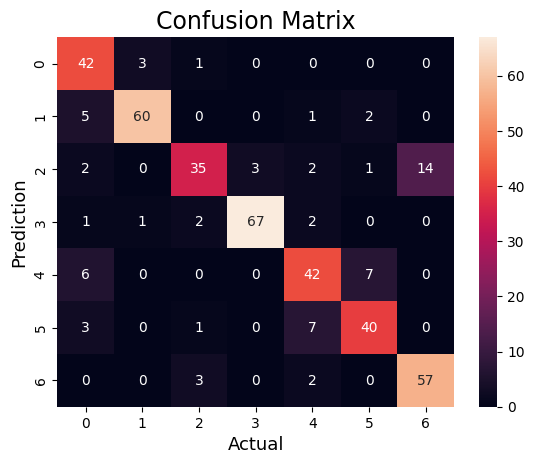

weighted_f1 =  0.8312799147942856


In [ ]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear", "sigmoid"], "C": [1, 10, 100, 1000]},
    {"kernel": ["poly"], "degree": [2,3], "C": [1, 10, 100, 1000]},
]

scores = "f1_weighted"

grid_search = GridSearchCV(
    SVC(), tuned_parameters, scoring=scores
)

model, report, val_acc, weighted_f1 = model_pipeline(feature_vectors_train, y_train, feature_vectors_test, y_test, grid_search)
print('weighted_f1 = ', weighted_f1)

In [ ]:
grid_search.best_params_

{'C': 1000, 'degree': 3, 'kernel': 'poly'}

In [ ]:
y_pred = grid_search.predict(feature_vectors_test)
accuracy_score(y_test, y_pred)

0.8325242718446602

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
#x_scaled = preprocessing.maxabs_scale(feature_vectors_train + feature_vectors_test)

skf = StratifiedKFold(n_splits=4, shuffle = False)

accs = []

for i, (train_index, test_index) in enumerate(skf.split(feature_vectors_train + feature_vectors_test, y_train + y_test)):
  #Create a svm Classifier
  x_train_fold, x_test_fold = np.array(feature_vectors_train + feature_vectors_test)[train_index.astype(int)], np.array(feature_vectors_train + feature_vectors_test)[test_index.astype(int)]
  y_train_fold, y_test_fold = np.array(y_train + y_test)[train_index.astype(int)],  np.array(y_train + y_test)[test_index.astype(int)]

  clf = SVC(C =  1000, degree = 3, kernel = 'poly')

  #Train the model using the training sets
  clf.fit(x_train_fold, y_train_fold)

  #Predict the response for test dataset
  y_pred = clf.predict(x_test_fold)
  acc = accuracy_score(y_test_fold, y_pred)
  accs.append(acc)
  print("Accuracy",i+1,' = ',acc)
print('avg accuracy = ', np.mean(np.array(accs)))
  #classes = ['angry', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']
  #print(classification_report(y_test, y_pred, target_names=classes))
  #confusion_matrix(y_test, y_pred)

Accuracy 1  =  0.8517441860465116
Accuracy 2  =  0.8309037900874635
Accuracy 3  =  0.7959183673469388
Accuracy 4  =  0.8483965014577259
avg accuracy =  0.83174071123466
